# 0710012 何權祐 HW2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
import re
from io import StringIO

%matplotlib inline

# Data Input

In [2]:
data = pd.read_csv(r'student_data/student-mat.csv',sep=';')
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


# Data Processing
## One-hot encode categorical features & Shuffle

In [3]:
from sklearn.utils import shuffle
data = shuffle(data)
data = pd.get_dummies(data)
feature = data.drop(columns=['G3']).reset_index(drop=True)
Label = pd.DataFrame(data.G3,columns=['G3']).reset_index(drop=True)
Label_B = Label.copy()
for i in range(len(Label)):
    if Label.G3[i] >= 10:
        Label_B.G3[i] = 'Pass'
    else:
        Label_B.G3[i] = 'Fail'

Label_F = Label.copy()
for i in range(len(Label)):
    if Label_F.G3[i] >= 16:
        Label_F.G3[i] = 'A'
    elif Label_F.G3[i] >= 14:
        Label_F.G3[i] = 'B'
    elif Label_F.G3[i] >= 12:
        Label_F.G3[i] = 'C'
    elif Label_F.G3[i] >= 10:
        Label_F.G3[i] = 'D'
    else:
        Label_F.G3[i] = 'F'
L5 = ['A','B','C','D','F']

# Principal components analysis (PCA)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
reduced = pca.fit_transform(feature)

# Model Construction

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from tabulate import tabulate

## Decision Tree
### No PCA_Binary

In [6]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
DT2_NCon = np.zeros((2,2))
DT2_NAcc_sum = 0
DT2_NPre_sum = 0
DT2_NRecall_sum = 0

for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.values[train_index], feature.values[test_index]
    y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
    clt = tree.DecisionTreeClassifier()
    clt.fit(X_train,y_train.ravel())
    DT2_Npredict = clt.predict(X_test)
    DT2_NAcc_sum += clt.score(X_test, y_test)
    DT2_NPre_sum += precision_score(y_test.flatten(),DT2_Npredict,average=None,labels=['Pass','Fail'])
    DT2_NRecall_sum += recall_score(y_test.flatten(),DT2_Npredict,average=None,labels=['Pass','Fail'])
    DT2_NCon += confusion_matrix(y_test,DT2_Npredict,labels=['Pass','Fail'])

print("Decision Tree without PCA(Binary):")
print("Accurancy:\n\t",round(DT2_NAcc_sum/3*100,2),"%\n")

d = [['Pass',round(DT2_NPre_sum[0]/3*100,2),round(DT2_NRecall_sum[0]/3*100,2)],
     ['Fail',round(DT2_NPre_sum[1]/3*100,2),round(DT2_NRecall_sum[1]/3*100,2)]]
print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((DT2_NCon/3).astype(int)))

Decision Tree without PCA(Binary):
Accurancy:
	 89.38 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   94.38                     89.43
Fail                   80.9                      89.22

Confusion Matrix:
 --  --
79   9
 4  38
--  --


### No PCA_5 level

In [7]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
DT5_NCon = np.zeros((5,5))
DT5_NAcc_sum = 0
DT5_NPre_sum = 0
DT5_NRecall_sum = 0

for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.values[train_index], feature.values[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = tree.DecisionTreeClassifier()
    clt.fit(X_train,y_train.ravel())
    DT5_Npredict = clt.predict(X_test)
    DT5_NAcc_sum += clt.score(X_test, y_test)
    DT5_NPre_sum += precision_score(y_test.flatten(),DT5_Npredict,average=None,labels=L5)
    DT5_NRecall_sum += recall_score(y_test.flatten(),DT5_Npredict,average=None,labels=L5)
    DT5_NCon += confusion_matrix(y_test,DT5_Npredict,labels=L5)

print("Decision Tree without PCA(5-level):")
print("Accurancy:\n\t",round(DT5_NAcc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(DT5_NPre_sum[i]/3*100,2),round(DT5_NRecall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((DT5_NCon/3).astype(int)))


Decision Tree without PCA(5-level):
Accurancy:
	 67.6 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      75.15                     70.88
B                      63.74                     62.07
C                      47.87                     48.62
D                      61.5                      59.72
F                      83.03                     84.43

Confusion Matrix:
 -  --  --  --  --
9   3   0   0   0
3  12   4   0   0
0   3  10   7   0
0   0   6  20   7
0   0   0   6  36
-  --  --  --  --


### With PCA_Binary

In [8]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
DT2_Con = np.zeros((2,2))
DT2_Acc_sum = 0
DT2_Pre_sum = 0
DT2_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
    clt = tree.DecisionTreeClassifier()
    clt.fit(X_train,y_train.ravel())
    DT2_predict = clt.predict(X_test)
    DT2_Acc_sum += clt.score(X_test, y_test)
    DT2_Pre_sum += precision_score(y_test.flatten(),DT2_predict,average=None,labels=['Pass','Fail'])
    DT2_Recall_sum += recall_score(y_test.flatten(),DT2_predict,average=None,labels=['Pass','Fail'])
    DT2_Con += confusion_matrix(y_test,DT2_predict,labels=['Pass','Fail'])

print("Decision Tree with PCA(Binary):")
print("Accurancy:\n\t",round(DT2_Acc_sum/3*100,2),"%\n")

d = [['Pass',round(DT2_Pre_sum[0]/3*100,2),round(DT2_Recall_sum[0]/3*100,2)],
     ['Fail',round(DT2_Pre_sum[1]/3*100,2),round(DT2_Recall_sum[1]/3*100,2)]]
print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((DT2_Con/3).astype(int)))

Decision Tree with PCA(Binary):
Accurancy:
	 86.33 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   88.94                     91.06
Fail                   80.95                     77.17

Confusion Matrix:
 --  --
80   8
10  33
--  --


### With PCA_5 level

In [9]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
DT5_Con = np.zeros((5,5))
DT5_Acc_sum = 0
DT5_Pre_sum = 0
DT5_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = tree.DecisionTreeClassifier()
    clt.fit(X_train,y_train.ravel())
    DT5_predict = clt.predict(X_test)
    DT5_Acc_sum += clt.score(X_test, y_test)
    DT5_Pre_sum += precision_score(y_test.flatten(),DT5_predict,average=None,labels=L5)
    DT5_Recall_sum += recall_score(y_test.flatten(),DT5_predict,average=None,labels=L5)
    DT5_Con += confusion_matrix(y_test,DT5_predict,labels=L5)

print("Decision Tree with PCA(5-level):")
print("Accurancy:\n\t",round(DT5_Acc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(DT5_Pre_sum[i]/3*100,2),round(DT5_Recall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((DT5_Con/3).astype(int)))

Decision Tree with PCA(5-level):
Accurancy:
	 60.77 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      62.18                     64.8
B                      49.76                     49.69
C                      39.95                     42.17
D                      54.56                     52.13
F                      79.25                     81.4

Confusion Matrix:
 -  --  -  --  --
8   4  0   0   0
4  10  4   1   0
1   4  8   6   0
0   0  7  17   9
0   0  1   7  35
-  --  -  --  --


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### No PCA(tree_num = 3, 25, 127)_Binary

In [11]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
tree_num = [3,25,127]
RF2_NAcc = []
RF2_NPre = []
RF2_NRecall = []
for i in range(3):
    RF2_NCon = np.zeros((2,2))
    RF2_NAcc_sum = 0
    RF2_NPre_sum = 0
    RF2_NRecall_sum = 0

    for train_index, test_index in kf.split(feature):
        X_train, X_test = feature.values[train_index], feature.values[test_index]
        y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
        clt = RandomForestClassifier(n_estimators=tree_num[i])
        clt.fit(X_train,y_train.ravel())
        RF2_Npredict = clt.predict(X_test)
        RF2_NAcc_sum += clt.score(X_test, y_test)
        RF2_NPre_sum += precision_score(y_test.flatten(),RF2_Npredict,average=None,labels=['Pass','Fail'])
        RF2_NRecall_sum += recall_score(y_test.flatten(),RF2_Npredict,average=None,labels=['Pass','Fail'])
        RF2_NCon += confusion_matrix(y_test,RF2_Npredict,labels=['Pass','Fail'])

    RF2_NAcc.append(round(RF2_NAcc_sum/3*100,2))
    RF2_NPre.append(np.round(RF2_NPre_sum/3*100,2))
    RF2_NRecall.append(np.round(RF2_NRecall_sum/3*100,2))

    print("Random Forest(tree_num =",tree_num[i],") without PCA(Binary):")
    print("Accurancy:\n\t",round(RF2_NAcc_sum/3*100,2),"%\n")

    d = [['Pass',round(RF2_NPre_sum[0]/3*100,2),round(RF2_NRecall_sum[0]/3*100,2)],
        ['Fail',round(RF2_NPre_sum[1]/3*100,2),round(RF2_NRecall_sum[1]/3*100,2)]]
    print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
    print("\nConfusion Matrix:\n",tabulate((RF2_NCon/3).astype(int)),"\n\n")

Random Forest(tree_num = 3 ) without PCA(Binary):
Accurancy:
	 86.84 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   90.17                     90.25
Fail                   79.99                     80.5

Confusion Matrix:
 --  --
79   8
 8  34
--  -- 


Random Forest(tree_num = 25 ) without PCA(Binary):
Accurancy:
	 89.62 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   91.86                     92.94
Fail                   85.54                     83.39

Confusion Matrix:
 --  --
82   6
 7  36
--  -- 


Random Forest(tree_num = 127 ) without PCA(Binary):
Accurancy:
	 90.9 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   94.51                     91.79
Fail                   84.38                     89.43

Confusion Matrix:
 -

### No PCA(tree_num = 127)_5 level

In [12]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
RF5_NCon = np.zeros((5,5))
RF5_NAcc_sum = 0
RF5_NPre_sum = 0
RF5_NRecall_sum = 0

for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.values[train_index], feature.values[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = RandomForestClassifier(n_estimators=127)
    clt.fit(X_train,y_train.ravel())
    RF5_Npredict = clt.predict(X_test)
    RF5_NAcc_sum += clt.score(X_test, y_test)
    RF5_NPre_sum += precision_score(y_test.flatten(),RF5_Npredict,average=None,labels=L5)
    RF5_NRecall_sum += recall_score(y_test.flatten(),RF5_Npredict,average=None,labels=L5)
    RF5_NCon += confusion_matrix(y_test,RF5_Npredict,labels=L5)

print("Random Forest(tree_num = 127 ) without PCA(5-level):")
print("Accurancy:\n\t",round(RF5_NAcc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(RF5_NPre_sum[i]/3*100,2),round(RF5_NRecall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((RF5_NCon/3).astype(int)))


Random Forest(tree_num = 127 ) without PCA(5-level):
Accurancy:
	 68.11 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      82.9                      64.58
B                      59.92                     63.91
C                      45.17                     29.21
D                      58.09                     67.22
F                      82.79                     91.6

Confusion Matrix:
 -  --  -  --  --
8   4  0   0   0
1  13  3   1   0
0   3  6  11   0
0   0  3  22   8
0   0  0   3  39
-  --  -  --  --


### With PCA(tree_num = 127)_Binary

In [13]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
RF2_Con = np.zeros((2,2))
RF2_Acc_sum = 0
RF2_Pre_sum = 0
RF2_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
    clt = RandomForestClassifier(n_estimators=127)
    clt.fit(X_train,y_train.ravel())
    RF2_predict = clt.predict(X_test)
    RF2_Acc_sum += clt.score(X_test, y_test)
    RF2_Pre_sum += precision_score(y_test.flatten(),RF2_predict,average=None,labels=['Pass','Fail'])
    RF2_Recall_sum += recall_score(y_test.flatten(),RF2_predict,average=None,labels=['Pass','Fail'])
    RF2_Con += confusion_matrix(y_test,RF2_predict,labels=['Pass','Fail'])

print("Random Forest(tree_num = 127 ) with PCA(Binary):")
print("Accurancy:\n\t",round(RF2_Acc_sum/3*100,2),"%\n")

d = [['Pass',round(RF2_Pre_sum[0]/3*100,2),round(RF2_Recall_sum[0]/3*100,2)],
     ['Fail',round(RF2_Pre_sum[1]/3*100,2),round(RF2_Recall_sum[1]/3*100,2)]]
print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((RF2_Con/3).astype(int)))

Random Forest(tree_num = 127 ) with PCA(Binary):
Accurancy:
	 88.62 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   91.63                     91.41
Fail                   82.78                     83.53

Confusion Matrix:
 --  --
80   7
 7  36
--  --


### With PCA(tree_num = 127)_5 level

In [14]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
RF5_Con = np.zeros((5,5))
RF5_Acc_sum = 0
RF5_Pre_sum = 0
RF5_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = RandomForestClassifier(n_estimators=127)
    clt.fit(X_train,y_train.ravel())
    RF5_predict = clt.predict(X_test)
    RF5_Acc_sum += clt.score(X_test, y_test)
    RF5_Pre_sum += precision_score(y_test.flatten(),RF5_predict,average=None,labels=L5)
    RF5_Recall_sum += recall_score(y_test.flatten(),RF5_predict,average=None,labels=L5)
    RF5_Con += confusion_matrix(y_test,RF5_predict,labels=L5)

print("Random Forest(tree_num = 127 ) with PCA(5-level):")
print("Accurancy:\n\t",round(RF5_Acc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(RF5_Pre_sum[i]/3*100,2),round(RF5_Recall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((RF5_Con/3).astype(int)))

Random Forest(tree_num = 127 ) with PCA(5-level):
Accurancy:
	 67.35 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      70.35                     64.38
B                      59.84                     66.19
C                      48                        37.08
D                      59.58                     56.51
F                      80.85                     91.92

Confusion Matrix:
 -  --  -  --  --
8   4  0   0   0
3  13  2   1   0
0   4  7   8   0
0   0  5  19   9
0   0  0   3  39
-  --  -  --  --


# KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

### No PCA(K = 3, 15, 39)_Binary

In [16]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
K_num = [3,9,39]
KNN2_NAcc = []
KNN2_NPre = []
KNN2_NRecall = []
for i in range(3):
    KNN2_NCon = np.zeros((2,2))
    KNN2_NAcc_sum = 0
    KNN2_NPre_sum = 0
    KNN2_NRecall_sum = 0

    for train_index, test_index in kf.split(feature):
        X_train, X_test = feature.values[train_index], feature.values[test_index]
        y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
        clt = KNeighborsClassifier(n_neighbors=K_num[i])
        clt.fit(X_train,y_train.ravel())
        KNN2_Npredict = clt.predict(X_test)
        KNN2_NAcc_sum += clt.score(X_test, y_test)
        KNN2_NPre_sum += precision_score(y_test.flatten(),KNN2_Npredict,average=None,labels=['Pass','Fail'])
        KNN2_NRecall_sum += recall_score(y_test.flatten(),KNN2_Npredict,average=None,labels=['Pass','Fail'])
        KNN2_NCon += confusion_matrix(y_test,KNN2_Npredict,labels=['Pass','Fail'])

    KNN2_NAcc.append(round(KNN2_NAcc_sum/3*100,2))
    KNN2_NPre.append(np.round(KNN2_NPre_sum/3*100,2))
    KNN2_NRecall.append(np.round(KNN2_NRecall_sum/3*100,2))

    print("KNN (K =",K_num[i],") without PCA(Binary):")
    print("Accurancy:\n\t",round(KNN2_NAcc_sum/3*100,2),"%\n")

    d = [['Pass',round(KNN2_NPre_sum[0]/3*100,2),round(KNN2_NRecall_sum[0]/3*100,2)],
        ['Fail',round(KNN2_NPre_sum[1]/3*100,2),round(KNN2_NRecall_sum[1]/3*100,2)]]
    print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
    print("\nConfusion Matrix:\n",tabulate((KNN2_NCon/3).astype(int)),"\n\n")

KNN (K = 3 ) without PCA(Binary):
Accurancy:
	 86.85 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   90.54                     89.93
Fail                   79.61                     81.33

Confusion Matrix:
 --  --
79   9
 8  35
--  -- 


KNN (K = 9 ) without PCA(Binary):
Accurancy:
	 89.62 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   91.77                     92.9
Fail                   85.22                     83.48

Confusion Matrix:
 --  --
82   6
 7  36
--  -- 


KNN (K = 39 ) without PCA(Binary):
Accurancy:
	 87.34 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   85.99                     97.06
Fail                   92.16                     68.39

Confusion Matrix:
 --  --
85   2
14  29
--  -- 




### No PCA(K = 15)_5 level

In [17]:
kf = KFold(n_splits=3)
kf.get_n_splits(feature)
KNN5_NCon = np.zeros((5,5))
KNN5_NAcc_sum = 0
KNN5_NPre_sum = 0
KNN5_NRecall_sum = 0

for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.values[train_index], feature.values[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = KNeighborsClassifier(n_neighbors=15)
    clt.fit(X_train,y_train.ravel())
    KNN5_Npredict = clt.predict(X_test)
    KNN5_NAcc_sum += clt.score(X_test, y_test)
    KNN5_NPre_sum += precision_score(y_test.flatten(),KNN5_Npredict,average=None,labels=L5)
    KNN5_NRecall_sum += recall_score(y_test.flatten(),KNN5_Npredict,average=None,labels=L5)
    KNN5_NCon += confusion_matrix(y_test,KNN5_Npredict,labels=L5)

print("KNN (K = 15 ) without PCA(5-level):")
print("Accurancy:\n\t",round(KNN5_NAcc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(KNN5_NPre_sum[i]/3*100,2),round(KNN5_NRecall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((KNN5_NCon/3).astype(int)))


KNN (K = 15 ) without PCA(5-level):
Accurancy:
	 66.33 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      87.14                     54.15
B                      55.81                     80.36
C                      45.54                     27.31
D                      59.26                     67.44
F                      82.42                     83.69

Confusion Matrix:
 -  --  -  --  --
7   5  0   0   0
1  16  2   0   0
0   6  5   8   0
0   0  3  22   7
0   0  0   7  36
-  --  -  --  --


### With PCA(K = 15)_Binary

In [18]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
KNN2_Con = np.zeros((2,2))
KNN2_Acc_sum = 0
KNN2_Pre_sum = 0
KNN2_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_B.values[train_index], Label_B.values[test_index]
    clt = KNeighborsClassifier(n_neighbors=15)
    clt.fit(X_train,y_train.ravel())
    KNN2_predict = clt.predict(X_test)
    KNN2_Acc_sum += clt.score(X_test, y_test)
    KNN2_Pre_sum += precision_score(y_test.flatten(),KNN2_predict,average=None,labels=['Pass','Fail'])
    KNN2_Recall_sum += recall_score(y_test.flatten(),KNN2_predict,average=None,labels=['Pass','Fail'])
    KNN2_Con += confusion_matrix(y_test,KNN2_predict,labels=['Pass','Fail'])

print("KNN (K = 15 ) with PCA(Binary):")
print("Accurancy:\n\t",round(KNN2_Acc_sum/3*100,2),"%\n")

d = [['Pass',round(KNN2_Pre_sum[0]/3*100,2),round(KNN2_Recall_sum[0]/3*100,2)],
     ['Fail',round(KNN2_Pre_sum[1]/3*100,2),round(KNN2_Recall_sum[1]/3*100,2)]]
print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((KNN2_Con/3).astype(int)))

KNN (K = 15 ) with PCA(Binary):
Accurancy:
	 88.86 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
Pass                   90.48                     93.29
Fail                   85.65                     80.4

Confusion Matrix:
 --  --
82   6
 8  34
--  --


### With PCA(K = 15)_5 level

In [19]:
kf = KFold(n_splits=3)
kf.get_n_splits(reduced)
KNN5_Con = np.zeros((5,5))
KNN5_Acc_sum = 0
KNN5_Pre_sum = 0
KNN5_Recall_sum = 0

for train_index, test_index in kf.split(reduced):
    X_train, X_test = reduced[train_index], reduced[test_index]
    y_train, y_test = Label_F.values[train_index], Label_F.values[test_index]
    clt = KNeighborsClassifier(n_neighbors=15)
    clt.fit(X_train,y_train.ravel())
    KNN5_predict = clt.predict(X_test)
    KNN5_Acc_sum += clt.score(X_test, y_test)
    KNN5_Pre_sum += precision_score(y_test.flatten(),KNN5_predict,average=None,labels=L5)
    KNN5_Recall_sum += recall_score(y_test.flatten(),KNN5_predict,average=None,labels=L5)
    KNN5_Con += confusion_matrix(y_test,KNN5_predict,labels=L5)

print("KNN (K = 15 ) with PCA(5-level):")
print("Accurancy:\n\t",round(KNN5_Acc_sum/3*100,2),"%\n")

d=[]
for i in range(5):
    d.append([L5[i],round(KNN5_Pre_sum[i]/3*100,2),round(KNN5_Recall_sum[i]/3*100,2)])

print(tabulate(d,headers=['class Name','Precision(%)','Sensitivity(Recall)(%)']))
print("\nConfusion Matrix:\n",tabulate((KNN5_Con/3).astype(int)))

KNN (K = 15 ) with PCA(5-level):
Accurancy:
	 66.08 %

class Name      Precision(%)    Sensitivity(Recall)(%)
------------  --------------  ------------------------
A                      89.68                     51.77
B                      56.53                     78.4
C                      44.17                     27.46
D                      58.09                     67.44
F                      81.81                     84.22

Confusion Matrix:
 -  --  -  --  --
6   6  0   0   0
0  15  3   0   0
0   5  5   8   0
0   0  3  22   7
0   0  0   7  36
-  --  -  --  --


# Comparison & Conclusion 
### Binary & 5-level
Model built with binary label performs well. No matter it is built by DT, RF, or KNN method, they all had a accuracy percentage over 80%. On the other hand, all of the model with 5-level label only had the accuracy percentage at about 50 to 60%.

---
## With/Without PCA.
Every model's accuracy drops when we apply the data after PCA into the training, which is obvious as we sure discarded some of the data. However, the drop in the percentage is only around 3 to 4 percent. Considering the much less calculation performed in the model building part, it is definitely worthy.

---
## Decision Tree & Random Forest & KNN
I will only compare the best performance in the three method to see the difference, as in practical, we will find the best number(tree_num, neighbor_num) to implement.

The Decision Tree has the lower accuracy out of the three method. In theory, as there are several DTs in Random Forest but only one tree in Decision Tree method, noise should effect Decision Tree method more, and so is the output performed  in the result.

As for KNN, no matter the neighbor is too few or too much, the result will be effected. Therefore, the best performance in my report is neighbors=15, which seemed to be affected less by noise. And the accuracy is higher than the Decision Tree but lower than the Random Forest method.

---
## Random Forest --> Different Tree number
If more tree are built in the forest, the accuracy should be higher, and the result in the report also showed as so. However, there is a maximum of the accuracy that cannot break through. That is, no matter how many trees were built in the model, the accuracy won't be higher than a certain value. 

---
## KNN --> Different Neighbor number
As mentioned in previous descripion, no matter the number of neighbors is too few or too many, the result will be effected by either the noise or the neighbors that outnumbered the needed information.

Therefore, there is a certain number of neighbor that can have the highest accuracy that differ from case to case. In my case, the closest number among the number of neighbors I choose is 15.

# Questions
## Decision Tree
>Show the prediction and reasoning of one arbitrary sample in the testing set.

Feature:
age              : 18		Medu             :  2		Fedu             :  1		traveltime       :  1		studytime        :  2
failures         :  1		famrel           :  5		freetime         :  4		goout            :  3		Dalc             :  1
Walc             :  1		health           :  5		absences         : 12		G1               : 12		G2               : 12
school_GP        :  1		school_MS        :  0		sex_F            :  1		sex_M            :  0		address_R        :  0
address_U        :  1		famsize_GT3      :  0		famsize_LE3      :  1		Pstatus_A        :  0		Pstatus_T        :  1
Mjob_at_home     :  0		Mjob_health      :  0		Mjob_other       :  0		Mjob_services    :  1		Mjob_teacher     :  0
Fjob_at_home     :  1		Fjob_health      :  0		Fjob_other       :  0		Fjob_services    :  0		Fjob_teacher     :  0
reason_course    :  0		reason_home      :  0		reason_other     :  0		reason_reputation:  1		guardian_father  :  0
guardian_mother  :  1		guardian_other   :  0		schoolsup_no     :  1		schoolsup_

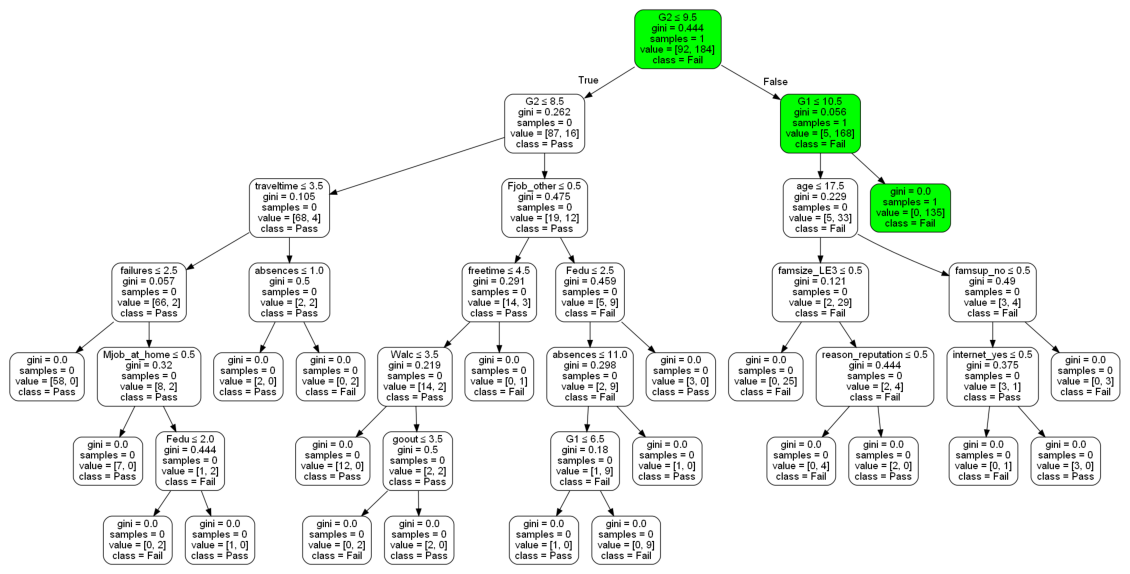

In [20]:
#import graphviz 
import pydotplus
import random
import matplotlib.image as img
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature,Label_B,train_size=0.7)
clt = tree.DecisionTreeClassifier()
clt.fit(X_train,y_train)

dot_data = tree.export_graphviz(clt, out_file=None, 
                                feature_names=feature.columns,  
                                class_names=['Pass','Fail'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

index = random.randint(0,len(y_test)-1)
samples = X_test.values[index:index+1]
decision_paths = clt.decision_path(samples)
state=''
print('Feature:')
for i in range(10):
    print('{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}'
            .format(feature.columns[i*5],str(samples[0][i*5]),feature.columns[i*5+1],str(samples[0][i*5+1]),
            feature.columns[i*5+2],str(samples[0][i*5+2]),feature.columns[i*5+3],str(samples[0][i*5+3]),feature.columns[i*5+4],str(samples[0][i*5+4])))

print('{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}'
            .format(feature.columns[55],str(samples[0][55]),feature.columns[56],str(samples[0][56]),
            feature.columns[57],str(samples[0][57])))

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))
        state = str(node.get_label().split('class = ')[1][0:4])

print('\nPredict state :',state)
if y_test.values[index]:
    T = 'Pass'
else:
    T = 'Fail'
print('True state :',T)
# plt.figure()
filename = 'tree.png'
a=graph.write_png(filename)
# print(type(graph.create_fig()))
image = img.imread('tree.png')
fig, ax = plt.subplots(figsize=(20,18))
ax.imshow(image)
ax.axis('off')
pass

## Random Forest
>Describe the difference between boosting and bagging

## Bagging
The concept of bagging is to divide the traing set into several subset and contruct machine learning models from each of the subset. When testing,  the prediction will be the majority of the prediction from each model. There won't be weights between each models. 

Goal : To reduce the effect of noise

## Boosting
The basic of Boosting is also dividing the traing set into serveral subset, and contruct models out of them. However, the models will be in order. The prediction of the previous model will effect the construction of the next model by adding the weight on the misclassified data, so that the new model can recover the error.

Goal : To build a model that can recover misclassified data 

## KNN
>Show the prediction and reasoning of one arbitrary sample in the testing set.

In [21]:
from sklearn import neighbors

X_train, X_test, y_train, y_test = train_test_split(
    feature,Label_B,train_size=0.7)
clt = KNeighborsClassifier(n_neighbors=3)
clt.fit(X_train,y_train.values.ravel())

index = random.randint(0,len(y_test)-1)
samples = X_test.values[index:index+1]

print('Feature:')
for i in range(10):
    print('{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}'
            .format(feature.columns[i*5],str(samples[0][i*5]),feature.columns[i*5+1],str(samples[0][i*5+1]),
            feature.columns[i*5+2],str(samples[0][i*5+2]),feature.columns[i*5+3],str(samples[0][i*5+3]),feature.columns[i*5+4],str(samples[0][i*5+4])))

print('{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}\t\t{:<17s}:{:>3s}'
            .format(feature.columns[55],str(samples[0][55]),feature.columns[56],str(samples[0][56]),
            feature.columns[57],str(samples[0][57])))

dis, ind = clt.kneighbors(samples, n_neighbors=3, return_distance=True)
index_t = [y_train.values[ind[0][0]][0],y_train.values[ind[0][1]][0],y_train.values[ind[0][2]][0]]
print('\n1st closest neighbor:\nDistance:',round(dis[0][0],2),'\tIndex:',ind[0][0],'\tLabel:',index_t[0])
print('2nd closest neighbor:\nDistance:',round(dis[0][1]),'\tIndex:',ind[0][1],'\tLabel:',index_t[1])
print('3rd closest neighbor:\nDistance:',round(dis[0][2]),'\tIndex:',ind[0][2],'\tLabel:',index_t[2])

values, counts = np.unique(index_t, return_counts=True)
n = np.argmax(counts)
print('\nPredict result:',values[n])

Feature:
age              : 18		Medu             :  2		Fedu             :  1		traveltime       :  1		studytime        :  3
failures         :  0		famrel           :  4		freetime         :  2		goout            :  4		Dalc             :  1
Walc             :  3		health           :  2		absences         :  6		G1               : 15		G2               : 14
school_GP        :  1		school_MS        :  0		sex_F            :  0		sex_M            :  1		address_R        :  0
address_U        :  1		famsize_GT3      :  1		famsize_LE3      :  0		Pstatus_A        :  0		Pstatus_T        :  1
Mjob_at_home     :  0		Mjob_health      :  0		Mjob_other       :  0		Mjob_services    :  1		Mjob_teacher     :  0
Fjob_at_home     :  0		Fjob_health      :  0		Fjob_other       :  0		Fjob_services    :  1		Fjob_teacher     :  0
reason_course    :  0		reason_home      :  0		reason_other     :  0		reason_reputation:  1		guardian_father  :  0
guardian_mother  :  1		guardian_other   :  0		schoolsup_no     :  1		schoolsup_

>Bonus: pick 2 features, draw and describe the KNN decision boundaries.
>>You can pick 2 features to re-train the model, or just fix every other feature value.

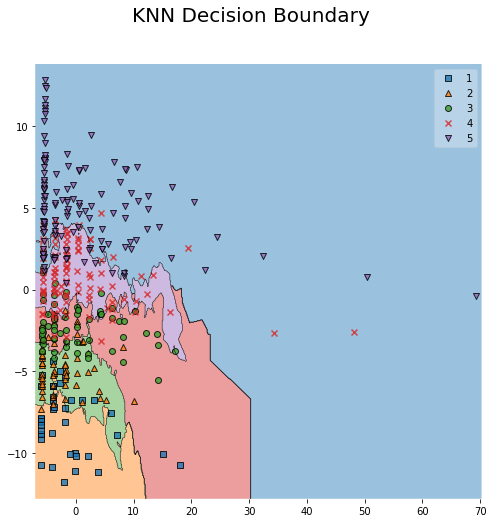

In [22]:
from mlxtend.plotting import plot_decision_regions

pca = PCA(n_components=2)
X = pca.fit_transform(feature)
clf = neighbors.KNeighborsClassifier(n_neighbors=15)
y=[]
for i in range(len(Label)):
    if Label.G3[i] >= 16:
        y.append(1)
    elif Label.G3[i] >= 14:
        y.append(2)
    elif Label.G3[i] >= 12:
        y.append(3)
    elif Label.G3[i] >= 10:
        y.append(4)
    else:
        y.append(5)
y = np.array(y)

clf.fit(X,y)

# Plotting decision region
fig_2, ax_2 = plt.subplots(figsize=(8,8))
fig_2.suptitle('KNN Decision Boundary',fontsize = 20)
plot_decision_regions(X, y, clf=clf)
pass

## PCA
>In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

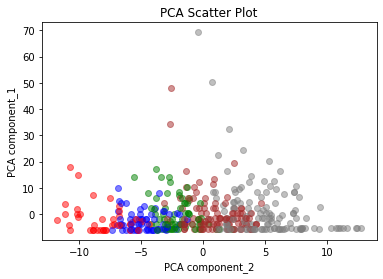

In [23]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(feature)

for i in range(len(reduced)):
    if Label_F.G3[i] == 'A':
        plt.scatter(reduced[i][1],reduced[i][0],c='red', alpha=0.5)
    elif Label_F.G3[i] == 'B':
        plt.scatter(reduced[i][1],reduced[i][0],c='blue', alpha=0.5)
    elif Label_F.G3[i] == 'C':
        plt.scatter(reduced[i][1],reduced[i][0],c='green', alpha=0.5)
    elif Label_F.G3[i] == 'D':
        plt.scatter(reduced[i][1],reduced[i][0],c='brown', alpha=0.5)
    else:
        plt.scatter(reduced[i][1],reduced[i][0],c='gray', alpha=0.5)

plt.xlabel("PCA component_2")
plt.ylabel("PCA component_1")
plt.title("PCA Scatter Plot")
plt.show()